#### CUDA SETTINGS

In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

#### IMPORTS

In [2]:
from reproduce.reproduce_utils import call_cfg_key, reconstruct_from_config, eval_ose, plot_results
from omegaconf import OmegaConf

#### IMPORTANT FILE PATHS

In [1]:
# downloaded cmems data
concatenated_6_nadirs_filepath = '/DATASET/OCB_traces/input_test_6sat_2017.nc'
test_1_nadir_filepath = '/DATASET/OCB_traces/concat/concatenated_ref_2017.nc'

# model hydra config
your_config = 'reproduce/config.yaml'
# best model ckpt path
best_ckpt_path = '/homes/p24hasle/repos/4dvarnet-starter-glorys12/outputs/2024-06-20/15-16-55/base_forecast_glorys12_10y/checkpoints/val_mse=26.93737-epoch=018.ckpt'
# name of the dir under which the reconstructed files will be stored
your_rec_dir = 'rec_dir'

# reconstructed files will be stored in <your_rec_dir>/reproduce/version_0/
REC_PATHS = '/homes/p24hasle/repos/4dvarnet-starter-glorys12/'+your_rec_dir+'/reproduce/version_0/test_data_{}.nc'

#### LOADING CONFIG

In [11]:
config = OmegaConf.load(your_config)

# override path to cmems input data
OmegaConf.update(config, key='paths.ose_6_sats', value=concatenated_6_nadirs_filepath)

### PREDICT WITH MODEL:

In [ ]:
reconstruct_from_config(config, your_rec_dir, best_ckpt_path)

### OSE RESULTS:

In [5]:
lead_times = range(13,20)

RMSE_array = []

for lead_time in lead_times:
    a,b = eval_ose(
        path_alongtrack = test_1_nadir_filepath,
        path_rec = REC_PATHS.format(lead_time),
        time_min = '2017-01-25',
        time_max= '2017-12-05'
    )

    print('leadtime {} - RMSE: {:.4f} | PSD: {:.4f}'.format(lead_time-lead_times[0], a, b))
    RMSE_array.append(a)

leadtime 0 - RMSE: 0.8330 | PSD: 15.0000
leadtime 1 - RMSE: 0.8134 | PSD: 15.0000
leadtime 2 - RMSE: 0.7867 | PSD: 173.0000
leadtime 3 - RMSE: 0.7712 | PSD: 69.0000
leadtime 4 - RMSE: 0.7530 | PSD: 53.0000
leadtime 5 - RMSE: 0.7406 | PSD: 13.0000
leadtime 6 - RMSE: 0.7091 | PSD: 276.0000


#### PLOT RESULTS

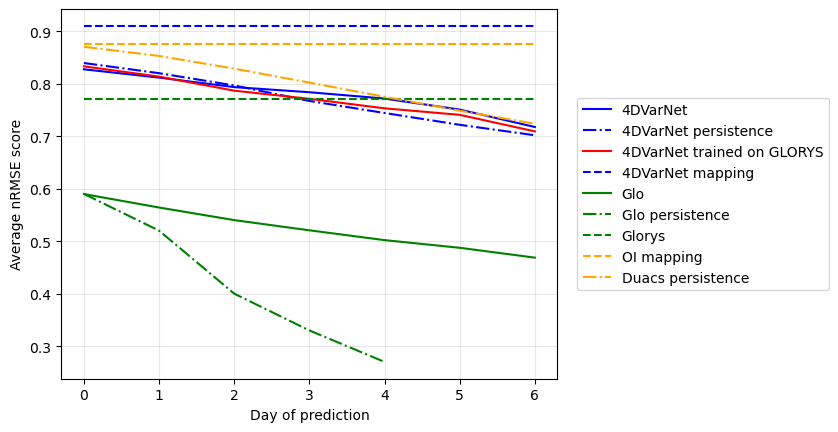

In [6]:
# save_name: named of saved graph if not None
plot_results(RMSE_array, save_name=None)